# Описание проекта 

Аналитика популярного сервиса аренды самокатов GoFast. Имеем данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

•	без подписки 
-	абонентская плата отсутствует;
-	стоимость одной минуты поездки — 8 рублей;
-	стоимость старта (начала поездки) — 50 рублей;

•	с подпиской Ultra 
-	абонентская плата — 199 рублей в месяц;
-	стоимость одной минуты поездки — 6 рублей;
-	стоимость старта — бесплатно.

Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — users_go.csv
	
`user_id`	уникальный идентификатор пользователя
`name`	имя пользователя
`age`	возраст
`city`	город
`subscription_type`	тип подписки (free, ultra)

Поездки — rides_go.csv
	
`user_id`	уникальный идентификатор пользователя

`distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)

`duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

`date`	дата совершения поездки

`Подписки` — subscriptions_go.csv
	
`subscription_type`	тип подписки

`minute_price`	стоимость одной минуты поездки по данной подписке

`start_ride_price`	стоимость начала поездки

`subscription_fee`	стоимость ежемесячного платежа



#### Шаг 1. Загрузка данных

Подгрузим необходимые библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

Загрузим и сразу посмотрим на файлы с данными.

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')
display(users.head(10))
display(rides.head(10))
subs.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.92,25.60,2021-01-01
1,1,2617.59,15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,2694.78,18.51,2021-08-11
4,1,4028.69,26.27,2021-08-28
5,1,2770.89,16.65,2021-10-09
6,1,3039.02,14.93,2021-10-19
7,1,2842.12,23.12,2021-11-06
8,1,3412.69,15.24,2021-11-14
9,1,748.69,15.04,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
display(users.info())
display(rides.info())
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [4]:
print(users.isna().sum())
print(rides.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
dtype: int64


Данные выглядят хорошо, пропусков нет, типы данных соответствующие. Даты поездок необходимо привести к более удобному формату.

In [5]:
display(users.describe())
display(rides.describe())

,user_id,age
count,1565.00,1565.00
mean,762.63,24.92
std,443.26,4.55
min,1.00,12.00
25%,378.00,22.00
50%,762.00,25.00
75%,1146.00,28.00
max,1534.00,43.00


,user_id,distance,duration
count,18068.00,18068.00,18068.00
mean,842.87,3070.66,17.81
std,434.73,1116.83,6.09
min,1.00,0.86,0.50
25%,487.00,2543.23,13.60
50%,889.00,3133.61,17.68
75%,1213.25,3776.22,21.72
max,1534.00,7211.01,40.82


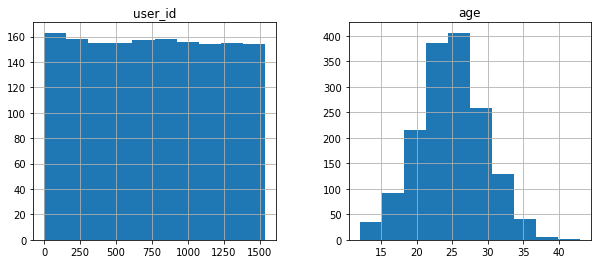

In [6]:
users.hist(figsize=(10, 4));

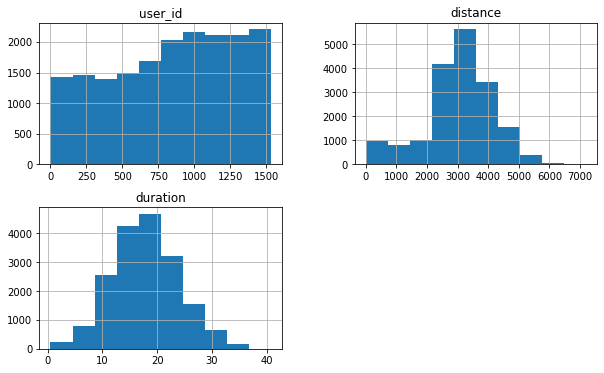

In [7]:
rides.hist(figsize=(10, 6));

Нормальное распределение данных для возраста, длительности и расстояния.

Ну и на диаграммы размаха для длительности и дальности поездок тоже посмотрим.

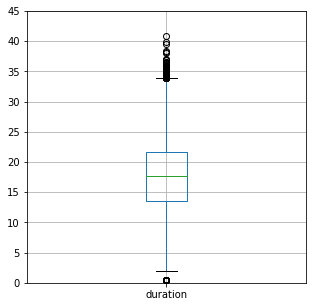

In [8]:
rides.boxplot('duration', figsize=(5,5)).set_ylim(0,45);

Нормальные значения для длительности поездки лежат в диапазоне от 2 до 34 минут.

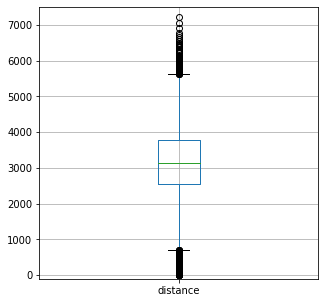

In [9]:
rides.boxplot('distance', figsize=(5,5)).set_ylim(-100,7500);

Нормальные значения для дальности поездки лежат в диапазоне от ~700 до ~5600 метров.

#### Шаг 2. Предобработка данных

Даты поездок сразу приведем к более удобному формату.

In [10]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

Проверим за какие года есть данные.

In [11]:
rides['date'].dt.year.unique()

array([2021])

Т.к. все данные только за 2021 год, то добавим столбец с номером месяца от дат поездок.

In [12]:
rides['month'] = rides['date'].dt.month
rides.info()
print(sorted(rides['month'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Проверим файлы с пользователями и поездками на повторы. Для пользователей достаточно сравнить по user_id, т.к. имена, возраст и город могут повторяться и это нормально. В поездках придется проверить дубликаты строк целиком, т.к. один и тот же пользователь мог совершить несколько поездок в разное время.

In [13]:
print('Повторов в записях о пользователях:',users['user_id'].duplicated().sum())
print(users['user_id'].value_counts())
print('Повторов в записях о поездках:', rides.duplicated().sum())


Повторов в записях о пользователях: 31
209     2
807     2
611     2
43      2
737     2
       ..
520     1
519     1
518     1
517     1
1534    1
Name: user_id, Length: 1534, dtype: int64
Повторов в записях о поездках: 0


Дубликаты в файле с пользователями уберем.

In [14]:
users = users.drop_duplicates().reset_index(drop=True)

#### Шаг 3. Исследовательский анализ данных

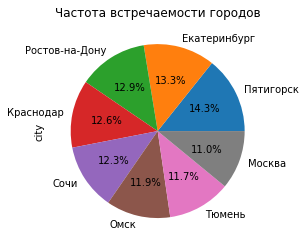

In [15]:
users['city'].value_counts().plot(kind='pie', autopct='%.1f%%'); 
plt.title('Частота встречаемости городов');

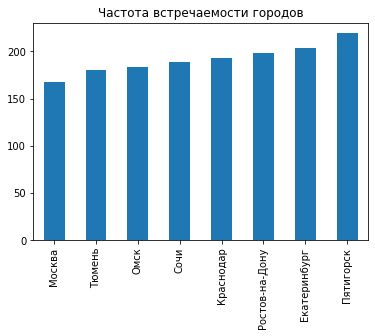

In [16]:
users['city'].value_counts(ascending=True).plot.bar(); 
plt.title('Частота встречаемости городов');

Не проглядывается какой-то зависимости популярности сервиса от города или климатической зоны, в которой этот город находится. Больше всего пользователей из Пятигорска, меньше всего из Москвы. Хотя в Москве ожидаемо могло бы быть наибольшее число пользователей всвязи с наибольшей плотностью населения. Возможно, в столице высокая конкуренция среди сервисов аренды самокатов.

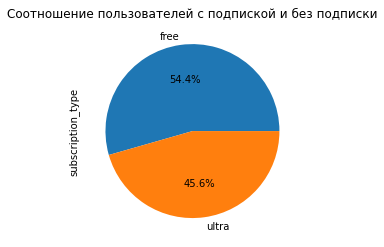

In [17]:
users['subscription_type'].value_counts().plot(kind='pie', autopct='%.1f%%'); 
plt.title('Соотношение пользователей с подпиской и без подписки');

Пользователей без подписки всего на 8.8 п.п. (138 человек) больше. То есть, чуть меньше половины пользователей предпочитают пользоваться сервисом регулярно и, вполне возможно, готовы рекомендовать его знакомым. Очень неплохой результат.

count   1534.00
mean      24.90
std        4.57
min       12.00
25%       22.00
50%       25.00
75%       28.00
max       43.00
Name: age, dtype: float64

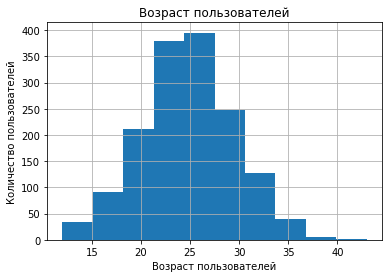

In [18]:
display(users['age'].describe());
users['age'].hist()
plt.xlabel("Возраст пользователей")
plt.ylabel("Количество пользователей")
plt.title('Возраст пользователей');

Тут можно сказать, что основная масса пользователей сервиса это люди 22-27 лет. Самые юные пользователи 12-ти лет, самые возрастные - 43-х. Люди большего возраста, видимо, предпочитают более стандартный способ передвижения.

count   18068.00
mean     3070.66
std      1116.83
min         0.86
25%      2543.23
50%      3133.61
75%      3776.22
max      7211.01
Name: distance, dtype: float64

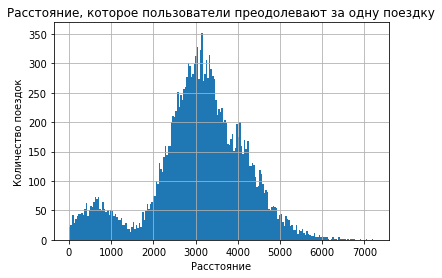

In [19]:
display(rides['distance'].describe());
rides['distance'].hist(bins=200)
plt.xlabel("Расстояние")
plt.ylabel("Количество поездок")
plt.title('Расстояние, которое пользователи преодолевают за одну поездку');

Стандартная дальность поездки в районе 3 километров. Максимальная была 7,2 км. Поездки менее 2,5 и более 3,5 встречаются значительно реже.

count   18068.00
mean       17.81
std         6.09
min         0.50
25%        13.60
50%        17.68
75%        21.72
max        40.82
Name: duration, dtype: float64

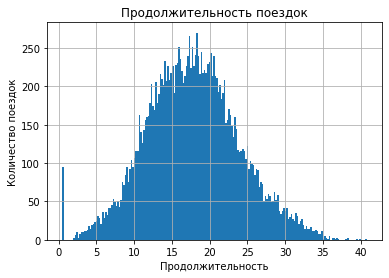

In [20]:
display(rides['duration'].describe());
rides['duration'].hist(bins=200)
plt.xlabel("Продолжительность")
plt.ylabel("Количество поездок")
plt.title('Продолжительность поездок');

Стандартная продолжительностью поездки около 12-21 минут. Есть видимая часть поездок продожительностью в 1 минуту. Вероятно, пользователи, которые просто тестировали работу сервиса.

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм, продолжительность поездок округлим до целых минут в большую сторону

In [21]:
data = users.merge(rides,on='user_id',how='outer')
df = data.merge(subs,on='subscription_type',how='outer')
df['duration'] = df['duration'].round().astype('int')

И посмотрим на результат.

In [22]:
display(df.head())
df.info()
df.describe()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(3)
memory usage: 1.8+ MB


,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,18068.00,18068.00,18068.00,18068.00,18068.00,18068.00,18068.00,18068.00
mean,842.87,24.89,3070.66,17.80,6.49,7.28,32.01,71.59
std,434.73,4.58,1116.83,6.10,3.44,0.96,24.00,95.51
min,1.00,12.00,0.86,0.00,1.00,6.00,0.00,0.00
25%,487.00,22.00,2543.23,14.00,4.00,6.00,0.00,0.00
50%,889.00,25.00,3133.61,18.00,6.00,8.00,50.00,0.00
75%,1213.25,28.00,3776.22,22.00,9.00,8.00,50.00,199.00
max,1534.00,43.00,7211.01,41.00,12.00,8.00,50.00,199.00


Теперь создадим два отдельных датафрейма для пользователей с подпиской и без неё.

In [23]:
free_users = df.query("subscription_type == 'free'")
paid_users = df.query("subscription_type == 'ultra'")

display(free_users.head())
paid_users.head()


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17,2021-02-14,2,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26,2021-08-28,8,6,0,199


Медианная дистанция поездок для пользователей без подписки: 3114 метров.
Медианная дистанция поездок для пользователей с подпиской: 3148 метров.


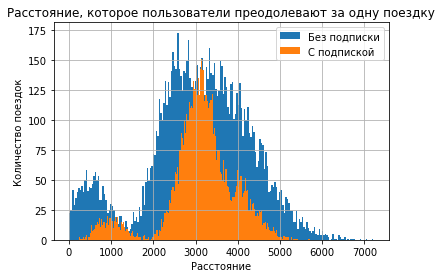

In [24]:
free_users['distance'].hist(bins=200,label='Без подписки')
paid_users['distance'].hist(bins=200,label='С подпиской')
plt.legend(fontsize=10)
plt.xlabel("Расстояние")
plt.ylabel("Количество поездок")
plt.title('Расстояние, которое пользователи преодолевают за одну поездку');
print('Медианная дистанция поездок для пользователей без подписки:',free_users['distance'].median().astype('int'),'метров.')
print('Медианная дистанция поездок для пользователей с подпиской:',paid_users['distance'].median().astype('int'),'метров.')

Пользователи без подписки чаще всего тратят на поездку: 17 минут.
Пользователи с подпиской чаще всего тратят на поездку: 18 минут.


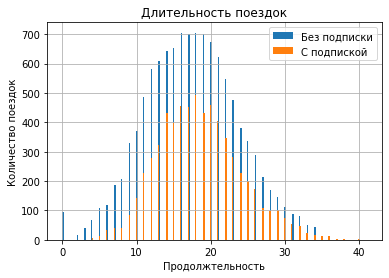

In [25]:
free_users['duration'].hist(bins=200,label='Без подписки');
paid_users['duration'].hist(bins=200,label='С подпиской');
plt.legend(fontsize=10)
plt.xlabel("Продолжтельность")
plt.ylabel("Количество поездок")
plt.title('Длительность поездок');
print('Пользователи без подписки чаще всего тратят на поездку:',free_users['duration'].mode().mean().astype('int'),'минут.')
print('Пользователи с подпиской чаще всего тратят на поездку:',paid_users['duration'].mode().mean().astype('int'),'минут.')

В целом дальность и длительность поездок пользователей с подпиской и без очень похожи.

#### Шаг 5. Подсчёт выручки

Объединим данные о поездках пользователей по месяцам, просуммируем продолжительность всех поездок в рамках каждого месяца.

In [26]:
revenue_free = free_users.groupby(['user_id', 'month','subscription_type'])\
.agg({'distance':'sum','duration':'sum', 'user_id':'count'})\
.rename(columns={'duration':'month_rides_duration','user_id':'rides_total_in_month'})

revenue_paid = paid_users.groupby(['user_id', 'month','subscription_type'])\
.agg({'distance':'sum','duration':'sum', 'user_id':'count'})\
.rename(columns={'duration':'month_rides_duration','user_id':'rides_total_in_month'})

display(revenue_free.head())
revenue_paid.head()

distance  month_rides_duration  \
user_id month subscription_type                                   
700     1     free                2515.69                    15   
        2     free               13446.66                    85   
        3     free                3798.33                    18   
        4     free                2984.55                    15   
        6     free                5927.65                    28   

                                 rides_total_in_month  
user_id month subscription_type                        
700     1     free                                  1  
        2     free                                  5  
        3     free                                  1  
        4     free                                  1  
        6     free                                  2

distance  month_rides_duration  \
user_id month subscription_type                                   
1       1     ultra               7027.51                    42   
        4     ultra                754.16                     6   
        8     ultra               6723.47                    45   
        10    ultra               5809.91                    32   
        11    ultra               7003.50                    53   

                                 rides_total_in_month  
user_id month subscription_type                        
1       1     ultra                                 2  
        4     ultra                                 1  
        8     ultra                                 2  
        10    ultra                                 2  
        11    ultra                                 3

Напишем функцию для подсчета месячной выручки с каждого пользователя и сольем данные в единый датафрейм с выручкой.

In [27]:
def costs_f(row):
    fee = (row['month_rides_duration'] * 8) + (row['rides_total_in_month'] * 50)
    total = 0
    for i in [fee]:
        if i > 0:
            total += i
    return total

def costs_p(row):
    fee = 199 + (row['month_rides_duration'] * 6)
    total = 0
    for i in [fee]:
        if i > 0:
            total += i
    return total

revenue_free['total_month_fee'] = revenue_free.apply(costs_f, axis=1)
revenue_paid['total_month_fee'] = revenue_paid.apply(costs_p, axis=1)
revenue = pd.concat([revenue_free, revenue_paid]).sort_index()


revenue.head(10)

distance  month_rides_duration  \
user_id month subscription_type                                   
1       1     ultra               7027.51                    42   
        4     ultra                754.16                     6   
        8     ultra               6723.47                    45   
        10    ultra               5809.91                    32   
        11    ultra               7003.50                    53   
        12    ultra               6751.63                    28   
2       3     ultra              10187.72                    61   
        4     ultra               6164.38                    39   
        6     ultra               3255.34                    14   
        7     ultra               6780.72                    46   

                                 rides_total_in_month  total_month_fee  
user_id month subscription_type                                         
1       1     ultra                                 2           451.00  
        4     ultra                                 1           235.00  
        8     ultra                                 2           469.00  
        10    ultra                                 2           391.00  
        11    ultra                                 3           517.00  
        12    ultra                                 2           367.00  
2       3     ultra                                 3           565.00  
        4     ultra                                 2           433.00  
        6     ultra                                 1           283.00  
        7     ultra                                 2           475.00

#### Шаг 6. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Сравниваем время поездок платных пользователей с бесплатными, значит первая гипотеза будет звучать так:
- Н0 Средняя продолжительность поездок пользователей с подпиской и без равны
- Н1 Средняя продолжительность поездок пользователей с подпиской больше, чем средняя продолжительность поездок пользователей без подписки

In [28]:
paid_duration = paid_users['duration']

free_duration = free_users['duration']


alpha = 0.05
 
results = st.ttest_ind(paid_duration, free_duration)
 
print('p-значение:', results.pvalue)
 
if (results.pvalue/2) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Среднее время поездок для пользователей без подписки:', free_users['duration'].mean().round())
print('Среднее время поездок для пользователей c подпиской:', paid_users['duration'].mean().round())

p-значение: 6.320137887122363e-35
Отвергаем нулевую гипотезу
Среднее время поездок для пользователей без подписки: 17.0
Среднее время поездок для пользователей c подпиской: 19.0


Благодаря тесту отвергли гипотезу о равентсве среднего времени поездки для пользователей с подпиской и без. По средним значениям видим, что среднее время поездок для пользователей c подпиской больше. 

Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Вторая гипотеза будет звучать так:
- Н0 Расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метрам

- Н1 Расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров

In [29]:
paid_distance = paid_users['distance']

opt_distance = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    paid_distance, 
    opt_distance,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

print('Среднее расстояние поездок для пользователей c подпиской:', paid_users['distance'].mean().round())

p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу
Среднее расстояние поездок для пользователей c подпиской: 3115.0


Тест и среднее значение показывают, что пользователи с подпиской, в среднем, ездят на расстояние не превышающее 3130 метров.

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем третью гипотезу:

- Н0 Выручка от пользователей с подпиской и выручка от пользователей без подписки равны

- Н1 Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

In [30]:
paid_fee = revenue_paid['total_month_fee']

free_fee = revenue_free['total_month_fee']


alpha = 0.05
 
results = st.ttest_ind(paid_fee, free_fee)
 
print('p-значение:', results.pvalue)
 
if (results.pvalue/2) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Средняя помесячная выручка пользователей без подписки:', revenue_free['total_month_fee'].mean().round())
print('Средняя помесячная выручка пользователей c подпиской:', revenue_paid['total_month_fee'].mean().round())


p-значение: 3.454813975677593e-37
Отвергаем нулевую гипотезу
Средняя помесячная выручка пользователей без подписки: 322.0
Средняя помесячная выручка пользователей c подпиской: 359.0


Благодаря тесту отвергли гипотезу о равентсве средней выручки от пользователей с подпиской и без. По средним значениям видим, что средняя выручка от пользователей c подпиской больше. 

# Задача 6.4
Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. 
Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. 
Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 
Какой тест вам понадобился бы для проверки этой гипотезы?

Тут подойдет Т-тест для парных выборок st.ttest_rel(before, after).

#### Шаг 7. Выводы

Мы проанализировали данные сервиса аренды самокатов, провели предобработку данных и построили графики, посчитали выручку и проверили несколько гипотез.

- География

Не проглядывается какой-то зависимости популярности сервиса от города или климатической зоны, в которой этот город находится. Больше всего пользователей из Пятигорска, меньше всего из Москвы. 

- Как часто люди покупают подписку

Пользователей без подписки всего на 8.8 п.п. (138 человек) больше.

- Аудитория

Основная масса пользователей сервиса — это люди 22-27 лет. Самые юные пользователи 12-ти лет, самые возрастные - 43-х.

- Поездки

Стандартная дальность поездки в районе 2,5 - 3,5 километров и продолжительность около 12-21 минут.
В целом дальность и длительность поездок пользователей с подпиской и без очень похожи.

- Гипотезы, которые были отвергнуты:

1. Средняя продолжительность поездок пользователей с подпиской и без равны.

2. Выручка от пользователей с подпиской и выручка от пользователей без подписки равны.

- Гипотезы, которые не были отвергнуты:

1. Средняя продолжительность поездок пользователей с подпиской больше, чем средняя продолжительность поездок пользователей без подписки.

2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше или равно 3130 метрам.

3. Выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.
